In [1]:
# Import required libraries
import torch
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchvision.transforms import functional as F
from io import BytesIO
from scipy.ndimage import gaussian_filter

In [2]:
# # Load pre-trained StyleGAN2 model using NVIDIA's implementation
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
# import sys
# sys.path.append('stylegan2-ada-pytorch')

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 1.13 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (57/57), done.


ModuleNotFoundError: No module named 'legacy'

In [10]:
cp /kaggle/working/stylegan2-ada-pytorch/legacy.py /kaggle/working/

In [13]:
cp -r /kaggle/working/stylegan2-ada-pytorch/dnnlib /kaggle/working/

In [15]:
cp -r /kaggle/working/stylegan2-ada-pytorch/torch_utils /kaggle/working/

In [4]:
!wget 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'

--2024-05-09 14:26:03--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 3.163.158.83, 3.163.158.113, 3.163.158.75, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|3.163.158.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: 'ffhq.pkl'

ffhq.pkl            100%[===================>] 363.94M   263MB/s    in 1.4s    

2024-05-09 14:26:06 (263 MB/s) - 'ffhq.pkl' saved [381624121/381624121]



In [16]:
import legacy
# # Load pre-trained StyleGAN2 generator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl'
with open('ffhq.pkl', 'rb') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)

In [21]:
cd /kaggle/working/

/kaggle/working


In [17]:
# Generate a batch of random images
def generate_images(G, z_dim=512, batch_size=8):
    z = torch.randn([batch_size, z_dim], device=device)
    label = torch.zeros([batch_size, G.c_dim], device=device)
    images = G(z, label, truncation_psi=0.5)
    return images

# Utility function to convert tensor to PIL image
def tensor_to_pil(tensor):
    array = tensor.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    return PIL.Image.fromarray(array)

# Display generated images
def display_images(images, num_images=8):
    plt.figure(figsize=(16, 16))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(tensor_to_pil(images[i]))
        plt.axis('off')
    plt.show()

# Apply image degradation pipeline
class ImageDegradationPipeline(nn.Module):
    def __init__(self, blur_sigma=2, noise_std=0.05, jpeg_quality=50):
        super(ImageDegradationPipeline, self).__init__()
        self.blur_sigma = blur_sigma
        self.noise_std = noise_std
        self.jpeg_quality = jpeg_quality

    def forward(self, img):
        img = self.apply_gaussian_blur(img)
        img = self.add_noise(img)
        img = self.apply_jpeg_compression(img)
        return img

    def apply_gaussian_blur(self, img):
        img = img.cpu().detach().numpy().transpose(1, 2, 0)
        img = gaussian_filter(img, sigma=self.blur_sigma)
        img = torch.from_numpy(img.transpose(2, 0, 1)).float().to(device)
        return img

    def add_noise(self, img):
        noise = torch.randn_like(img) * self.noise_std
        return img + noise

    def apply_jpeg_compression(self, img):
        pil_img = tensor_to_pil(img)
        buffer = BytesIO()
        pil_img.save(buffer, format='JPEG', quality=self.jpeg_quality)
        compressed_img = PIL.Image.open(buffer)
        return F.to_tensor(compressed_img).to(device)

# Apply degradation pipeline to generated images
def degrade_images(images, pipeline):
    degraded_images = []
    for img in images:
        degraded_img = pipeline(img)
        degraded_images.append(degraded_img)
    return torch.stack(degraded_images)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Original Images:


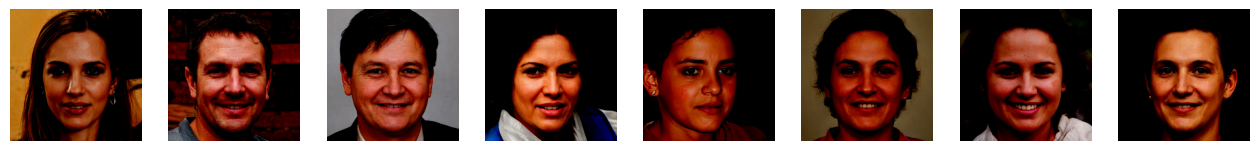

Degraded Images:


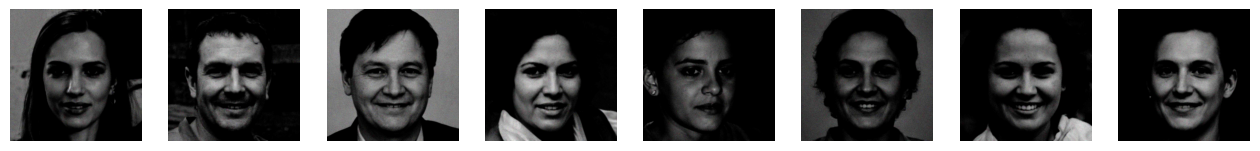

In [18]:
# Generate random images using pre-trained StyleGAN2 generator
images = generate_images(G)

# Display original images
print("Original Images:")
display_images(images)

# Initialize degradation pipeline
degradation_pipeline = ImageDegradationPipeline(blur_sigma=3, noise_std=0.1, jpeg_quality=30)

# Apply degradation pipeline
degraded_images = degrade_images(images, degradation_pipeline)

# Display degraded images
print("Degraded Images:")
display_images(degraded_images)

# # Save degraded images
# def save_images(images, prefix='degraded_image'):
#     for i, img in enumerate(images):
#         pil_img = tensor_to_pil(img)
#         pil_img.save(f'{prefix}_{i}.png')

# save_images(degraded_images, prefix='degraded_image')

Projecting: 100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s]


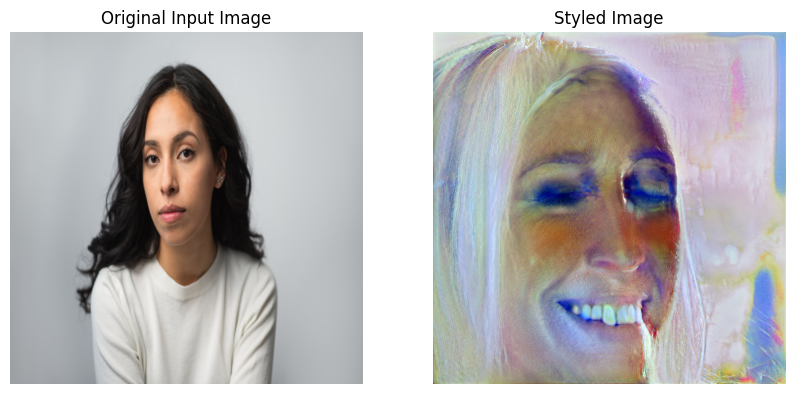

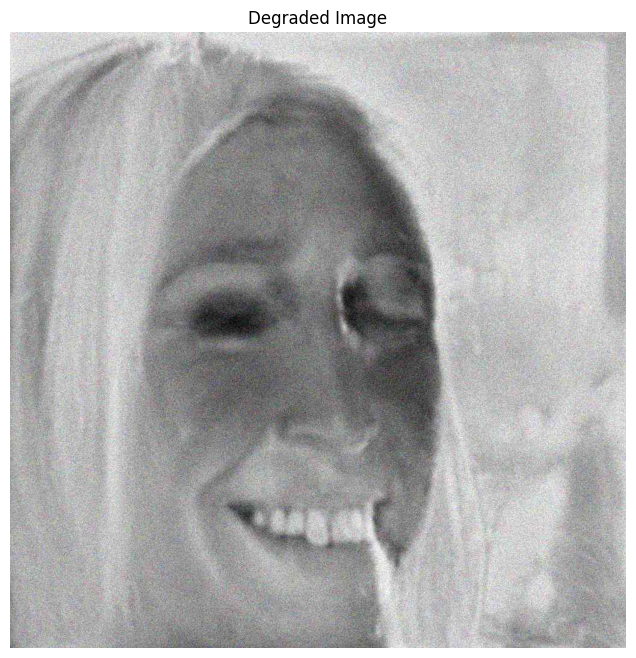

In [19]:
from tqdm import tqdm

# Function to load and preprocess the input image
def load_image(image_path, target_size=1024):
    img = PIL.Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((target_size, target_size)),
        transforms.ToTensor()
    ])
    return transform(img).unsqueeze(0).to(device)

# Project input image to the latent space
def project_image_to_latent_space(G, img, num_steps=1000, learning_rate=0.1):
    z_dim = G.z_dim
    z = torch.randn([1, z_dim], device=device).detach().requires_grad_(True)
    optimizer = torch.optim.Adam([z], lr=learning_rate)

    for step in tqdm(range(num_steps), desc="Projecting"):
        optimizer.zero_grad()
        generated_img = G(z, None, truncation_psi=1.0)
        loss = torch.nn.functional.mse_loss(generated_img, img)
        loss.backward()
        optimizer.step()

    return z

# Load content image
content_image_path = '/kaggle/input/img-dls/portrait.jpeg'
content_image = load_image(content_image_path)

# Project content image into latent space
latent_vector = project_image_to_latent_space(G, content_image)

# Generate the styled image using the latent vector
def generate_styled_image(G, latent_vector, style_path):
    style_image = load_image(style_path)
    generated_image = G(latent_vector, None, truncation_psi=1.0)
    return generated_image

# Generate image using the projected latent vector
style_image_path = '/kaggle/input/img-dls/WhatsApp Image 2024-05-05 at 16.04.49.jpeg'
generated_image = generate_styled_image(G, latent_vector, style_image_path)

# Display original and styled images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(tensor_to_pil(content_image.squeeze()))
plt.title("Original Input Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(tensor_to_pil(generated_image.squeeze()))
plt.title("Styled Image")
plt.axis('off')
plt.show()

# Utility function to convert tensor to PIL image
def tensor_to_pil(tensor):
    array = tensor.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    return PIL.Image.fromarray(array)

# Apply image degradation pipeline
class ImageDegradationPipeline(nn.Module):
    def __init__(self, blur_sigma=2, noise_std=0.05, jpeg_quality=50):
        super(ImageDegradationPipeline, self).__init__()
        self.blur_sigma = blur_sigma
        self.noise_std = noise_std
        self.jpeg_quality = jpeg_quality

    def forward(self, img):
        img = self.apply_gaussian_blur(img)
        img = self.add_noise(img)
        img = self.apply_jpeg_compression(img)
        return img

    def apply_gaussian_blur(self, img):
        img = img.cpu().detach().numpy().transpose(1, 2, 0)
        img = gaussian_filter(img, sigma=self.blur_sigma)
        img = torch.from_numpy(img.transpose(2, 0, 1)).float().to(device)
        return img

    def add_noise(self, img):
        noise = torch.randn_like(img) * self.noise_std
        return img + noise

    def apply_jpeg_compression(self, img):
        pil_img = tensor_to_pil(img)
        buffer = BytesIO()
        pil_img.save(buffer, format='JPEG', quality=self.jpeg_quality)
        compressed_img = PIL.Image.open(buffer)
        return F.to_tensor(compressed_img).to(device)

# Initialize degradation pipeline
degradation_pipeline = ImageDegradationPipeline(blur_sigma=3, noise_std=0.1, jpeg_quality=30)

# Apply degradation pipeline
def degrade_image(image, pipeline):
    return pipeline(image.squeeze(0))

degraded_image = degrade_image(generated_image, degradation_pipeline)

# Display degraded image
plt.figure(figsize=(8, 8))
plt.imshow(tensor_to_pil(degraded_image))
plt.title('Degraded Image')
plt.axis('off')
plt.show()